# Visual Question Answering using Multimodal Transformer Models

## Import necessary libraries & set up the environment

In [2]:
from google.colab import drive

drive.mount("/content/drive")

%cd '/content/drive/MyDrive/DL_Project/VQA-With-Multimodal-Transformers-main/'

!sudo apt-get install python3.8


!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -r requirements3.txt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DL_Project/VQA-With-Multimodal-Transformers-main
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.8 is already the newest version (3.8.10-0ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**Load data**

For demonstration purposes, we download the train and validation sets of DAQAR datasets since it is a small dataset. We download:

Both train and validation sets are available in the form of .csv files.

In [3]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
import requests
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging,
    #ViLT Stuff
    ViltProcessor, ViltForQuestionAnswering
)
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

from tqdm import tqdm

validation_size = 5673
train_size = 6795
epochs = 10
learning_rate = 5e-6

2023-07-14 19:32:45.719894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package wordnet to /root/nltk_data...


Read the data from csv file and structure in the form that the can be given to vilt model. DAQAR data is structured in the form of VQAv2 dataset.

In [5]:
# Adapted from: https://github.com/tezansahu/VQA-With-Multimodal-Transformers/blob/main/notebooks/VisualQuestionAnsweringWithTransformers.ipynb

dataset = load_dataset(
    "csv",
    data_files={
        "train": os.path.join("dataset", "data_train.csv"),
        "test": os.path.join("dataset", "data_eval.csv")
    }
)

with open(os.path.join("dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

print(dataset)
questions_train = []
annotations_train = []
for i in range(dataset["train"].num_rows):
    questions_train.append({"question": dataset["train"][i]["question"],
                    "image_id":dataset["train"][i]["image_id"],
                    "question_id":str(i)})
    answers_list = []
    answers = dataset["train"][i]["answer"].split(",")
    j=0
    for answer in answers:
        j+=1
        answers_list.append({"answer":answer,
                             "answer_id":j})
    annotations_train.append({"answers":  answers_list,
                        "image_id": dataset["train"][i]["image_id"],
                        "question_id":str(i)})
questions_eval = []
annotations_eval = []
for i in range(dataset["test"].num_rows):
    questions_eval.append({"question": dataset["test"][i]["question"],
                    "image_id":dataset["test"][i]["image_id"],
                    "question_id":str(i)})
    answers_list = []
    answers = dataset["test"][i]["answer"].split(",")
    j=0
    for answer in answers:
        j+=1
        answers_list.append({"answer":answer,
                             "answer_id":j})
    annotations_eval.append({"answers":  answers_list,
                        "image_id": dataset["test"][i]["image_id"],
                        "question_id":str(i)})

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-3afae4910f2d9b9c/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['answer', 'image_id', 'label', 'question'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['answer', 'image_id', 'label', 'question'],
        num_rows: 2494
    })
})


In [6]:
#check the total number of questions
print("Number of questions:", len(questions_train))

#find what a question looks like
questions_train[0]

Number of questions: 9974


{'question': 'what is the object on the shelves',
 'image_id': 'image100',
 'question_id': '0'}

Each question is related to an image with certain ID. The function below allows to get ID from a corresponding filename

In [7]:
import re
from typing import Optional

# source: https://github.com/allenai/allennlp-models/blob/a36aed540e605c4293c25f73d6674071ca9edfc3/allennlp_models/vision/dataset_readers/vqav2.py#L141
def id_from_filename(filename: str):
    id = filename.split(".")[0]
    return id

In [9]:
from os import listdir
from os.path import isfile, join

# root at which all images are stored
root = '/content/drive/MyDrive/DL_Project/VQA-With-Multimodal-Transformers-main/dataset/images'
file_names = listdir(root)

#example of filename to ID
id_from_filename('image123542.jpg')

'image123542'

Create two dictionaries that map filename to ID and ID to filename

In [10]:
filename_to_id = {root + "/" + file: id_from_filename(file) for file in file_names}
id_to_filename = {v:k for k,v in filename_to_id.items()}

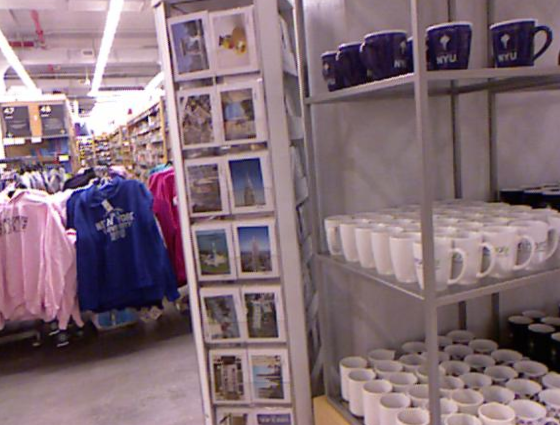

In [11]:
from PIL import Image

path = id_to_filename[questions_train[0]['image_id']]
image = Image.open(path)
image

**Read Annotations**

In [13]:
# import json

# # Read annotations
# f = open('/content/drive/MyDrive/ViLT/Datasets/v2_mscoco_val2014_annotations.json')

# # Return JSON object as dictionary
# data_annotations = json.load(f)
# print(data_annotations.keys())

# #every image is annotated with multiple possible answers and there is a bit of ambiguity in what could be the right answer.
# annotations = data_annotations['annotations']
# print("Number of annotations:", len(annotations))

annotations_train[0]

{'answers': [{'answer': 'cup', 'answer_id': 1}],
 'image_id': 'image100',
 'question_id': '0'}

**Add labels + scores**

Most authors treat VQAv2 as a multi-label classification problem as multiple answers are possiblly valid. We would like to give higher score to the answer that is most probably. A score of 1.0 is assigned to labels that are counted at least 3 times and a score of < 1.0 is given to labels that are counted less.

In [14]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [15]:
from tqdm.notebook import tqdm

def get_score(count: int) -> float:
    return 1.0

for annotation in tqdm(annotations_train):
    answers = annotation['answers']
    answer_count = {}
    for answer in answers:
        answer_ = answer["answer"]
        answer_count[answer_] = answer_count.get(answer_, 0) + 1
    labels = []
    scores = []
    for answer in answer_count:
        if answer not in list(config.label2id.keys()):
            continue
        labels.append(config.label2id[answer])
        score = get_score(answer_count[answer])
        scores.append(score)
    # added labels and scores key to annotations dict. Labels contain the ID's of answers for classification. The corresponding score of the label IDs are stored in scores key.
    annotation['labels'] = labels
    annotation['scores'] = scores

for annotation in tqdm(annotations_eval):
    answers = annotation['answers']
    answer_count = {}
    for answer in answers:
        answer_ = answer["answer"]
        answer_count[answer_] = answer_count.get(answer_, 0) + 1
    labels = []
    scores = []
    for answer in answer_count:
        if answer not in list(config.label2id.keys()):
            continue
        labels.append(config.label2id[answer])
        score = get_score(answer_count[answer])
        scores.append(score)
    annotation['labels'] = labels
    annotation['scores'] = scores

annotations_train[0]
annotations_eval[0]

  0%|          | 0/9974 [00:00<?, ?it/s]

  0%|          | 0/2494 [00:00<?, ?it/s]

{'answers': [{'answer': 'pink', 'answer_id': 1}],
 'image_id': 'image399',
 'question_id': '0',
 'labels': [42],
 'scores': [1.0]}

**Create pytorch dataset**

Next, we create a regular PyTorch dataset. We leverage ViltProcessor to prepare each image + text pair for the model, which will automatically:

leverage BertTokenizerFast to tokenize the text and create input_ids, attention_mask and token_type_ids
leverage ViltFeatureExtractor to resize + normalize the image and create pixel_values and pixel_mask.
Note that the docs of ViltProcessor can be found here.

We also add the labels. This is a PyTorch tensor of shape (num_labels,) that contains the soft encoded vector.

In [16]:
import torch
from PIL import Image

class DAQARDataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, questions, annotations, processor):
        self.questions = questions
        self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image + text
        annotation = self.annotations[idx]
        questions = self.questions[idx]
        image = Image.open(id_to_filename[annotation['image_id']])
        text = questions['question']

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        labels = annotation['labels']
        scores = annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(config.id2label))
        for label, score in zip(labels, scores):
              targets[label] = score
        encoding["labels"] = targets

        return encoding

In [18]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

dataset_train = DAQARDataset(questions=questions_train[:train_size],
                     annotations=annotations_train[:train_size],
                     processor=processor)

dataset_eval = DAQARDataset(questions=questions_eval[:validation_size],
                     annotations=annotations_eval[:validation_size],
                     processor=processor)

In [ ]:
dataset_train[0].keys()

processor.decode(dataset_train[0]['input_ids'])

labels = torch.nonzero(dataset_train[0]['labels']).squeeze().tolist()

[config.id2label[label] for label in labels]

**Define model**

Here we define a ViltForQuestionAnswering model, with the weights of the body initialized from dandelin/vilt-b32-mlm, and a randomly initialized classification head. We also move it to the GPU, if it's available.

In [19]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 num_labels=len(config.id2label),
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
model.to(device)

ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

Pytorch dataset is created which allows us to iterate over the dataset in batches

In [21]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset_train, collate_fn=collate_fn, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(dataset_eval, collate_fn=collate_fn, batch_size=4, shuffle=True)

batch = next(iter(train_dataloader))

for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 384, 480])
pixel_mask torch.Size([4, 384, 480])
labels torch.Size([4, 3129])


Wu-Palmer score calculation functions

In [22]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a)
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score

def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(config.id2label[label], config.id2label[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

**Train the model**

In [25]:
#load checkpoint

# checkpoint = torch.load('full_train.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [27]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
losses_train = []
losses_eval = []
wup_epoch_best_train = []
wup_epoch_best_eval = []
wup_epoch_avg_train = []
wup_epoch_avg_eval = []

bestest_wup_train = 0
bestest_wup_eval = 0

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
     print(f"Epoch: {epoch}")
     loss_value = 0
     wup_score = 0
     wup_score_temp = []
     wup_best = 0

     model.train()
     for i in tqdm(train_dataloader):
          # get the inputs;
          batch = {k:v.to(device) for k,v in i.items()}

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(**batch)

          logits = outputs.logits
          preds = logits.argmax(dim=-1).tolist()
          labels = batch['labels'].argmax(dim=-1).tolist()
          wup_score = batch_wup_measure(labels, preds)
          wup_score_temp.append(wup_score)
          if wup_score > wup_best:
               wup_best = wup_score
          loss = outputs.loss
          loss_value = loss.item()
          loss.backward()
          optimizer.step()

     if wup_best > bestest_wup_train:
          bestest_wup_train = wup_best

     wup_epoch_best_train.append(wup_best)
     # print("Training Loss:", loss_value)
     # print("Training WUP Score Avg:", sum(wup_score_temp)/len(wup_score_temp))
     losses_train.append(loss_value)
     wup_epoch_avg_train.append(sum(wup_score_temp)/len(wup_score_temp))


     loss_value = 0
     wup_score = 0
     wup_best = 0
     wup_score_temp = []

     model.eval()
     for i in tqdm(eval_dataloader):
          # get the inputs;
          batch = {k:v.to(device) for k,v in i.items()}
          outputs = model(**batch)
          logits = outputs.logits
          preds = logits.argmax(dim=-1).tolist()
          labels = batch['labels'].argmax(dim=-1).tolist()
          wup_score = batch_wup_measure(labels, preds)
          wup_score_temp.append(wup_score)
          if wup_score > wup_best:
               wup_best = wup_score
          loss = outputs.loss
          loss_value = loss.item()

     if wup_best > bestest_wup_eval:
          bestest_wup_eval = wup_best

     # print("Evaluation Loss:", loss_value)
     # print("Evaluation WUP Score:", sum(wup_score_temp)/len(wup_score_temp))
     wup_epoch_avg_eval.append(sum(wup_score_temp)/len(wup_score_temp))
     losses_eval.append(loss_value)
     wup_epoch_best_eval.append(wup_best)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/1699 [00:00<?, ?it/s]

FileNotFoundError: ignored

***************************************
Epochs: 10, train size = 6795, validation size = 5673, LR = 5e-06
Final Training Loss: 4.24815034866333
Final Evaluation Loss: 5.913775444030762
Final Training WUP Score: 0.273993003294196
Final Evaluation WUP Score: 0.27368076048448226
Best Training WUP Score: 1.0
Best Evaluation WUP Score: 1.0
***************************************
[37.89479064941406, 14.879653930664062, 9.124641418457031, 6.794430732727051, 3.3744938373565674, 5.433416366577148, 4.1569647789001465, 4.4662089347839355, 4.24815034866333]
[37.4094123840332, 11.092926025390625, 6.21115255355835, 6.828422546386719, 3.3175671100616455, 5.158517360687256, 2.218888521194458, 3.737253189086914, 5.913775444030762]


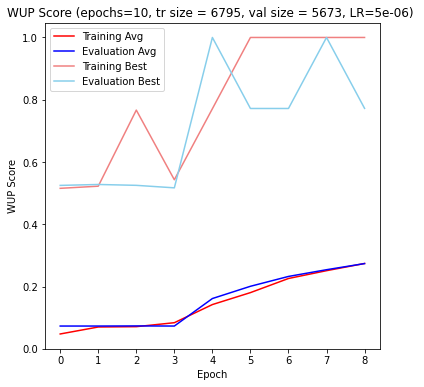

<Figure size 432x288 with 0 Axes>

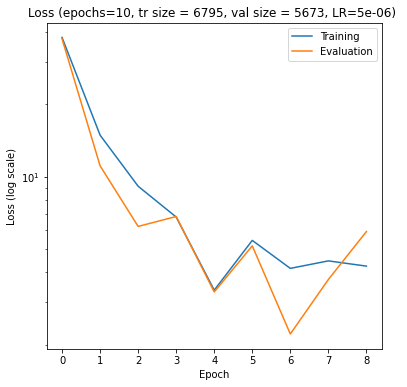

<Figure size 432x288 with 0 Axes>

In [30]:
print("***************************************")
print(f'Epochs: {epochs}, train size = {train_size}, validation size = {validation_size}, LR = {learning_rate}')
print(f'Final Training Loss: {losses_train[-1]}')
print(f'Final Evaluation Loss: {losses_eval[-1]}')
print(f'Final Training WUP Score: {wup_epoch_avg_train[-1]}')
print(f'Final Evaluation WUP Score: {wup_epoch_avg_eval[-1]}')
print("Best Training WUP Score:", bestest_wup_train)
print("Best Evaluation WUP Score:", bestest_wup_eval)
print("***************************************")
print(losses_train)
print(losses_eval)

from matplotlib import pyplot as plt

plt.figure(figsize=(6,6))
plt.title(f'WUP Score (epochs={epochs}, tr size = {train_size}, val size = {validation_size}, LR={learning_rate}) ')
plt.ylabel("WUP Score")
plt.xlabel("Epoch")
plt.plot(wup_epoch_avg_train, color="red")
plt.plot(wup_epoch_avg_eval, color="blue")
plt.plot(wup_epoch_best_train, color="lightcoral")
plt.plot(wup_epoch_best_eval, color= "skyblue")
plt.legend(["Training Avg", "Evaluation Avg", "Training Best", "Evaluation Best"])
plt.show()
# plt.savefig("wup_score.png")
plt.clf()

plt.figure(figsize=(6,6))
plt.title(f'Loss (epochs={epochs}, tr size = {train_size}, val size = {validation_size}, LR={learning_rate}) ')
plt.ylabel("Loss (log scale)")
plt.xlabel("Epoch")
plt.yscale("log")
plt.plot(losses_train)
plt.plot(losses_eval)
plt.legend(["Training", "Evaluation"])
plt.show()
# plt.savefig("loss.png")
plt.clf()

In [36]:
EPOCH = 50
PATH = "full_train.pt"
LOSS = losses_eval[-1]
torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, '/content/sample_data/model.pt')

**Inference**

In [ ]:
example = dataset[0]
print(example.keys())

# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[predicted_class])